In [1]:
import casadi as ca
import casadi.tools as cat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import networkx as nx
import sys, copy
from scipy.integrate import solve_ivp
import matlab.engine

sys.path.append('.')
sys.path.append('ocp-solving/')

from ItalySetup import ItalySetup

from utils import *

eng = matlab.engine.start_matlab()
eng.cd('geography-paper-master/', nargout=0)
eng.run('single_build.m', nargout=0)

model_size = 107

s = ItalySetup(model_size)

N = 163           # Number of control time interval
T = 163           #52 * 7       # N * 7
n_int_steps = 1

model_days = pd.date_range(s.start_date, s.end_date, freq='1D')
freq = '1D'  # 'W-MON'
model_step = pd.date_range(s.start_date, s.end_date, freq=freq)
mobintime = s.mobility_ts.resample(freq).mean()

N = len(model_step) - 1
T = len(model_days)

N = 30
T = 31

nx = 9

states_list = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = states_list

S, E, P, I, A, Q, H, R, V = np.arange(nx)

integ_matlab = np.array(eng.eval('x'))

p_dict, mobfrac, mobmat, betaratiointime, x0 = get_parameters_from_matlab(eng, s, model_size, model_days, freq)

dt = T / N / n_int_steps

obj_params = {
    'scale_ell': 1e4,
    'scale_If': 0,
    'scale_v': 1e-8
}
obj_params = {
    'scale_ell': 1e0,
    'scale_If': 1e2,
    'scale_v': 1e-6
}
betaP0 = p_dict['betaP0']
epsilonA = p_dict['epsilonA']
epsilonI = p_dict['epsilonI']
r = p_dict['r']

p_dict.pop('betaP0')
p_dict.pop('r')
p_dict.pop('epsilonA')
p_dict.pop('epsilonI')
C = mobmat

Loaded Italy Setup with 107 nodes.


In [2]:
def rhs_py(t, x, u, cov, p, mob, pop_node):
    S, E, P, I, A, Q, H, R, V = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8]

    deltaE, deltaP,sigma,eta,gammaI,gammaA,gammaQ,gammaH,alphaI,alphaH, zeta,  gammaV = \
    p[0], p[1], p[2], p[3], p[4], p[5], p[6], p[7], p[8], p[9], p[10], p[11]
   
    v = u[0]
    foi = mob
    rhs = [None] * nx
    vaccrate = v / (S + E + P + A + Q + H + R+1)  # NOT I NOT H ?
    vaccrate = v / ca.sqrt((S+E+P+A+Q+H+R)**2+10)   # 10 (1e7 ?1e3 ?)is to tune depending on scale, approx abs. value (brings quantities non negative by vaccinating)
    vaccrate = 0
    rhs[0] = -(foi + vaccrate) * S + gammaV * V                 # S
    rhs[1] = foi * S - deltaE * E;                              # E 
    rhs[2] = deltaE * E - deltaP * P;                           # P
    rhs[3] = sigma * deltaP * P - (eta + gammaI + alphaI) * I;  # I
    rhs[4] = (1 - sigma) * deltaP * P - gammaA * A;             # A
    rhs[5] = zeta * eta * I - gammaQ * Q;                       # Q
    rhs[6] = (1 - zeta) * eta * I - (gammaH + alphaH) * H;      # H
    rhs[7] = gammaI * I + gammaA * A + gammaH * H + gammaQ * Q;  # R
    rhs[8] = vaccrate * S - gammaV * V                           # V
    rhs_ell = [None] * 3
    rhs_ell[0] = gammaH * H;  # recovered from the hospital
    rhs_ell[1] = alphaH * H;  # total death
    rhs_ell[2] = (1 - zeta) * eta * I;  # cumulative hospitalized cases

    return rhs, rhs_ell

In [3]:
setup = s
model_params = copy.copy(p_dict)
ind2name = setup.ind2name
#ind_to_plot = setup.ind_to_plot
pop_node = setup.pop_node

M = setup.nnodes
mobility = setup.mobility

print(f'Building OCP with {M} nodes')

c = setup.mobility

scale_ell = obj_params['scale_ell']
scale_If = obj_params['scale_If']
scale_v = obj_params['scale_v']
pnum = params_to_vector(model_params)

pnum.append(scale_ell)
pnum.append(scale_If)
pnum.append(scale_v)

# ---- decision variables ---------
states = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']
states = cat.struct_symSX(states)
[S, E, P, I, A, Q, H, R, V] = states[...]

controls = cat.struct_symSX(['v', 'mob'])
[v, mob] = controls[...]

covar = cat.struct_symSX(['J'])
[J] = covar[...]

params = cat.struct_symSX(list(model_params.keys()) + ['scale_ell', 'scale_If', 'scale_v'])
[deltaE, deltaP, sigma, eta, gammaI, gammaA, gammaQ, gammaH, alphaI, alphaH, zeta, gammaV,
 scale_ell, scale_If, scale_v] = params[...]

pop_nodeSX = ca.SX.sym('pop_node')


# The rhs is at time zero, the time is also no used in the equation so that exoplain
rhs, rhs_ell = rhs_py(0, states.cat, controls.cat, covar.cat, params.cat, mob, pop_nodeSX)
rhs = ca.veccat(*rhs)
rhs_ell = ca.veccat(*rhs_ell)  # mod

Building OCP with 107 nodes


In [4]:
frhs = ca.Function('frhs', [states, controls, covar, params, pop_nodeSX],
                           [rhs, rhs_ell[1]])#scale_ell * rhs_ell[1] + scale_v * v * v])# mod ICI juste ell[1]

In [5]:
frhs

Function(frhs:(i0[9],i1[2],i2,i3[15],i4)->(o0[9],o1) SXFunction)

In [6]:
dt = T / N / n_int_steps  # length of an integration interval
# ---- dynamic constraints --------
k1, k1ell = frhs(states, controls, covar, params, pop_nodeSX)
k2, k2ell = frhs(states + dt / 2 * k1, controls, covar, params, pop_nodeSX)
k3, k3ell = frhs(states + dt / 2 * k2, controls, covar, params, pop_nodeSX)
k4, k4ell = frhs(states + dt * k3, controls, covar, params, pop_nodeSX)
x_next = states + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
ell_next = dt / 6 * (
        k1ell + 2 * k2ell + 2 * k3ell + k4ell)  # No need for because we sum it week by week few lines below.

rk4_step = ca.Function('rk4_step', [states, controls, covar, params, pop_nodeSX], [x_next, ell_next])

In [7]:
# Overwrite last cell with eurler.
dt = T / N / n_int_steps  # length of an integration interval
a, b = frhs(states, controls, covar, params, pop_nodeSX)
x_next = states + dt*a
ell_next = dt*b
rk4_step = ca.Function('rk4_step', [states, controls, covar, params, pop_nodeSX], [x_next, ell_next])

In [8]:
x_ = ca.veccat(*states[...])
u_ = ca.veccat(*controls[...])
ell = 0.
VacPpl = states['S'] + states['E'] + states['P'] + states['A'] + states['R']
vaccrate = controls['v']/(VacPpl+1e-10)
x_[0] -= vaccrate * states['S']
x_[8] += vaccrate * states['S']
for k in range(n_int_steps):
    x_, ell_ = rk4_step(x_, u_,covar, params, pop_nodeSX)
    ell += ell_

In [9]:
rk4_int = ca.Function('rk4_int', [states, ca.veccat(controls, covar, params, pop_nodeSX)], [x_, ell],
                      ['x0', 'p'], ['xf', 'qf'])

# BUG TODO Isn't this a double multiplication by the scale parameter since ell is already multiplied ?
ell = ca.Function('ell', [states, controls, covar, params, pop_nodeSX],
                  [scale_ell * ell + scale_v * v * v, scale_ell * ell,
                   scale_v * v * v])  # Very dependent on regularization factor
#ell = ca.Function('ell', [states, controls, covar, params, pop_nodeSX],
#                  [ell, scale_ell * ell,
#                   scale_v * v * v])  # Very dependent on regularization factor

In [10]:
Vars = cat.struct_symMX([
    (
        cat.entry("x", struct=states, repeat=[M, N + 1]),
        cat.entry("u", struct=controls, repeat=[M, N]),
    ),
])

Params = cat.struct_symMX([
    (
        cat.entry("cov", struct=covar, repeat=[M, N]), 
        cat.entry("p", struct=params),
    ),
])

In [11]:
lbx = Vars(-np.inf)
ubx = Vars(np.inf)

f = 0
vaccines = 0
cases = 0
reg = 0
cdot_T = 0
dyn = [None] * N
spatial = [None] * N

mob_prun = -1
mob_prun = 0.0006


mobility_history = []

for k in range(N):
    mobK = mobintime.to_numpy().T[:,k]
    betaR = betaratiointime.to_numpy().T[:,k]
    C = r*mobfrac.flatten()*mobK*mobmat
    np.fill_diagonal(C,1-C.sum(axis=1)+ C.diagonal())
    
    dyn[k] = []
    spatial[k] = []
    Sk, Ek, Pk, Rk, Ak, Ik = ca.veccat(*Vars['x', :, k, 'S']), ca.veccat(*Vars['x', :, k, 'E']), \
                             ca.veccat(*Vars['x', :, k, 'P']), ca.veccat(*Vars['x', :, k, 'R']), \
                             ca.veccat(*Vars['x', :, k, 'A']), ca.veccat(*Vars['x', :, k, 'I'])

    if k == 0 or k == N-1:
        print(f'pruning {C[C<mob_prun].size} non-diagonal mobility elements of {C.size-M}.')  
    C[C<mob_prun] = 0 # Prune elements
    mobility_history.append(C)
    
    foi_sup = []
    foi_inf = []
    for n in range(M):
        foi_sup.append(betaP0*betaR[n]*(Pk[n]+epsilonA*Ak[n]))
        foi_inf.append(Sk[n]+Ek[n]+Pk[n]+Rk[n]+Ak[n])
    
    foi = []
    for m in range(M):
        foi.append((sum(C[n, m] * foi_sup[n] for n in range(M)) + epsilonI*betaP0*betaR[m]*Ik[m]) /
                   (sum(C[l, m] * foi_inf[l] for l in range(M)) + Ik[m]))
        

    print(f'{k}:', end='')
    for i in range(M):
        [X_, ell_ik] = rk4_int(Vars['x', i, k],
                               ca.veccat(Vars['u', i, k], Params['cov', i, k], Params['p'], pop_node[i]))

        dyn[k].append(Vars['x', i, k + 1] - X_)
        ell_ik_, cases_ik, reg_ik = ell(Vars['x', i, k], Vars['u', i, k], Params['cov', i, k], Params['p'], pop_node[i])
        f += ell_ik_ #MOD: before  ell_ik_
        cases += cases_ik
        reg += reg_ik
        #mob_ik = sum(C[i, m] * (
        #            (sum(C[n, m] * (betaP0*betaR[n]*(Pk[n]+epsilonA*Ak[n])) for n in range(M)) + 
        #             epsilonI*betaP0*betaR[m]*Ik[m]) /
        #            (sum(C[l, m]*(Sk[l]+Ek[l]+Pk[l]+Rk[l]+Ak[l]) for l in range(M)) + Ik[m]))
        #             for m in range(M))
        mob_ik = sum(C[i, m] * foi[m] for m in range(M))
        
        spatial[k].append(Vars['u', i, k, 'mob'] - mob_ik) # spatial, vaccines and dyn are put in g(x), with constraints that spatial and dyn are equal to zero
        # thus imposing the dynamics and coupling.
        vaccines += Vars[ 'u', i, k, 'v'] * T / N  # Number of vaccine spent = num of vaccine rate * 7 (number of days)

f /= T  # Average over interval for cost ^ but not terminal cost 

pruning 10921 non-diagonal mobility elements of 11342.
0:1:2:3:4:5:6:7:8:9:10:11:12:13:14:15:16:17:18:19:20:21:22:23:24:25:26:27:28:pruning 10921 non-diagonal mobility elements of 11342.
29:

In [12]:
print('Writing constraints, ...', end='')
g = cat.struct_MX([
    cat.entry("dyn", expr=dyn),
    cat.entry("spatial", expr=spatial),
    cat.entry("vaccines", expr=vaccines),
])

costTerms = ca.Function('costTerms', [Vars, Params], [cases, reg])


# This initialize
lbg = g(0)
ubg = g(0)


ubg['vaccines'] = 2000*(T*.6)*M #8e6 #*M
lbg['vaccines'] = -np.inf

optimize = 1
lbx['u', :, :, 'v'] = 0.
ubx['u', :, :, 'v'] = 2000 * optimize  # = 0 if we don't want to optimize
# ubx['u',:,:,'v'] = 0
#ubx['u', :, :1, 'v'] = 0.


# Set initial conditions as constraints
for cp, name in enumerate(states.keys()):
    for i in range(M):
        lbx['x', i, 0, name] = ubx['x', i, 0, name] = x0[i*nx+cp]

print('DONE')
print('Building NLP function...', end='')

# NLOP arguments:
# 'x' : variable names to optimize: here states and control
# 'p' : params that can be change after
# 'f' is the objective function of 'x', that we ought to minize
# 'g' is a function that goes lbg < g(x,p) < ubg. If you want equality constraint then ubg = lbg = the number yoiu want it to be.
nlp = {'x': Vars, 'p': Params, 'f': f, 'g': g}
nlpFun = ca.Function('nlpFun', [Vars, Params], [f, g])
print('DONE')
print('Building Jacobian function...', end='')
nlpJac = nlpFun.factory('nlpJac', ['i0', 'i1'], ['jac:o1:i0'])

print('DONE')
print('Building Solver...', end='')

options = {}
options['ipopt'] = {}
#options['ipopt']["linear_solver"] = "ma57"
options['ipopt']["linear_solver"] = "ma86"
# options['ipopt']["linear_solver"] = "ma86"
# options['ipopt']["linear_solver"] = "ma97"
# options['ipopt']['bound_frac'] = 1e-4
# options['ipopt']['bound_push'] = 1e-4
# options['ipopt']['slack_bound_frac'] = 1e-4
# options['ipopt']['slack_bound_push'] = 1e-6
# options['ipopt']['hessian_constant'] = 'yes'
# options['ipopt']["tol"] = 1e-8

solver = ca.nlpsol('solver', "ipopt", nlp, options)

# options = {}
# options['ls_step_factor'] = 0.5
# options['pr_tol'] = 1e-8
# options['du_tol'] = 1e-8
# options['qp_solver'] = 'nlpsol'
# options['qp_solver_options']  = {'nlpsol':'ipopt','nlpsol_options':{'print_time':False,'ipopt.print_level':0,'ipopt.hessian_constant':'yes','ipopt.linear_solver':'ma97','ipopt.tol':1e-16}}
# # options['regularization'] = 'regularize_reduced'
# options['regularization'] = 'regularize_reduced_diag'
# options['regularization_tol'] = 1e-10
# options['linesearch'] = 'filter'
# options["iteration_callback"] = plotIterates
# self.solver = SQPmethod(nlp,options)

print('DONE')

Writing constraints, ...DONE
Building NLP function...DONE
Building Jacobian function...DONE
Building Solver...DONE


In [13]:
integ_matlab = np.array(eng.eval('x'))

init = Vars(0)
for i, name in enumerate(states.keys()):
    for k in range(N + 1):
        # init['x',:,k,name] = sol0.y[i,k]
        for nd in range(M):
            init['x', nd, k, name] = integ_matlab.T[nd+107*i, k].T # p['x0']  # self.ic[name][i]

init['u'] = 0.

arg = {}
arg['lbg'] = lbg
arg['ubg'] = ubg

arg['lbx'] = lbx
arg['ubx'] = ubx
arg['x0'] = init
arg['p'] = Params()
# for i in range(M):

#    for k in range(N):
#        arg['p']['cov',i,k] = rainfall_norm[i,k]**params(pnum)['r']
# arg['p']['cov',i,k] = np.random.random()**params(pnum)['r']

arg['p']['p'] = pnum

In [14]:
#arg['ubx']['u', :, :, 'v']  = 0

In [15]:
# If restart:
#for i, name in enumerate(states.keys()):
#    for k in range(N + 1):
#        for nd in range(M):
#            init['x', nd, k, name] = opt['x',nd, k, name]
#for k in range(N):
#    for nd in range(M):       
#        init['u', nd, k, 'v'] = opt['u',nd,k,'v']        
    

In [16]:
#pnum.append(scale_ell)
#pnum.append(scale_If)
#pnum.append(scale_v)
pnum[-3] = 1e8
pnum[-2] = 0
pnum[-1] = 1e-30
pnum[-4] = 1/(9*30)  #gammaV 
arg['p']['p'] = pnum
arg['x0'] = init

In [17]:
sol = solver(**arg)
opt = Vars(sol['x'])
lam_g = g(sol['lam_g'])
lam_x = Vars(sol['lam_x'])
[fnum,gnum]=nlpFun(opt,arg['p'])
Jgnum=nlpJac(opt, arg['p'])
gnum = g(gnum)   # 2times ?
print(f"""
Vaccines stockpile: 
    {float(arg['ubg']['vaccines']):010f} total.
    {float(g(gnum)['vaccines']):010f} spent.
    {float((arg['ubg']['vaccines']  - g(gnum)['vaccines'])):010f} left.""")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:   376923
Number of nonzeros in inequality constraint Jacobian.:     3210
Number of nonzeros in Lagrangian Hessian.............:   660283

Total number of variables............................:    35310
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     3210
                     variables with only upper bounds:        0
Total number of equality constraints.................:    32100
Total number of inequality constrai

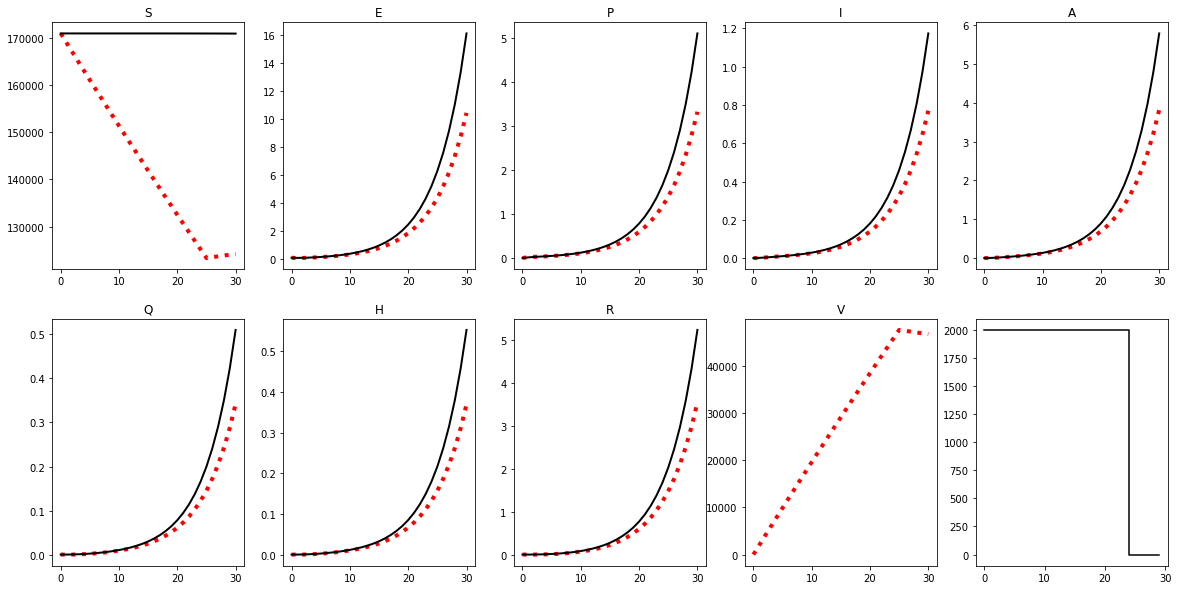

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2,5, figsize = (20,10))
node = 1
til =  T

for i, st in enumerate(states_list):
    axes.flat[i].plot(np.array(ca.veccat(*opt['x',node,:til,st])), 
                  linestyle=':', lw = 4, color='r')
    if st != 'V':
        axes.flat[i].plot(np.array(integ_matlab.T[node+107*i,:til].T), 
                  linestyle='-', lw = 2, color='k')

    axes.flat[i].set_title(st);

axes.flat[-1].step(np.array(ca.veccat(ca.veccat(*opt['u',node,:til,'v']))),#,opt['u',node,-1,'v'])),
                  'k',label=r"$\nu(t)$");

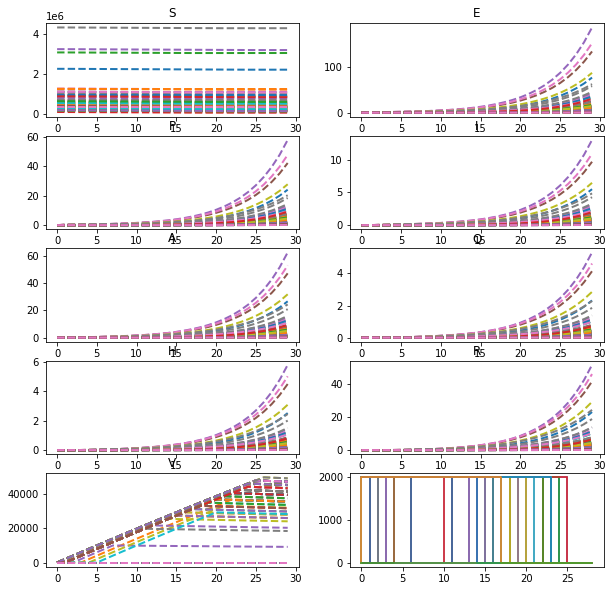

In [19]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5,2, figsize = (10,10))
node = 1
til =  -1

for i, st in enumerate(states_list):
    for k in range(M):
        axes.flat[i].plot(np.array(ca.veccat(*opt['x',k,:til,st])), 
                   lw = 2, ls = '--')
        #if st != 'V':
        #    axes.flat[i].plot(np.array(integ_matlab.T[k+107*i,:til].T), 
        #           lw = .5)
        axes.flat[i].set_title(st);
        axes.flat[-1].step(np.arange(len(np.array(ca.veccat(ca.veccat(*opt['u',k,:til,'v']))))),
                                         np.array(ca.veccat(ca.veccat(*opt['u',k,:til,'v'])))
                          )

In [20]:
import networkx
import geopandas as gpd

In [21]:
G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
s.shp['vacc'] = np.nan
s.shp['Rend'] = np.nan
for i, node in enumerate(s.ind2name):
    G.add_node(node)
    G.position[node] = (s.pos_node[i,0], s.pos_node[i,1])
    G.population[node] = s.pop_node[i]
    #G.comp[node] = (ocp.ic['S'][i], ocp.ic['I'][i],ocp.ic['R'][i])
    try:
        G.epi[node] = {'vacc': sum(np.array(ca.veccat(ca.veccat(*opt['u',i,:,'v']))))[0],
                   'Rend':                            float(opt['x',i,-1,'R'])}
        s.shp.loc[i, 'vacc'] = sum(np.array(ca.veccat(ca.veccat(*opt['u',i,:,'v']))))[0]
        s.shp.loc[i, 'Rend'] = float(opt['x',i,-1,'R'])
    except NameError as e:
        #print(f'epi data failed, {e}')
        G.epi[node] = {'vacc': np.nan,
                   'Rend':     np.nan}
        s.shp.loc[i, 'vacc'] = np.nan
        s.shp.loc[i, 'Rend'] = np.nan
        
    s.shp.loc[i, 'population'] =  s.pop_node[i] # overwrite 
    for j, connection in enumerate(mobility_history[0][i]):
        if connection != 0:
            G.add_edge(node, s.ind2name[j], weight=connection)

In [22]:
G.number_of_edges()

366

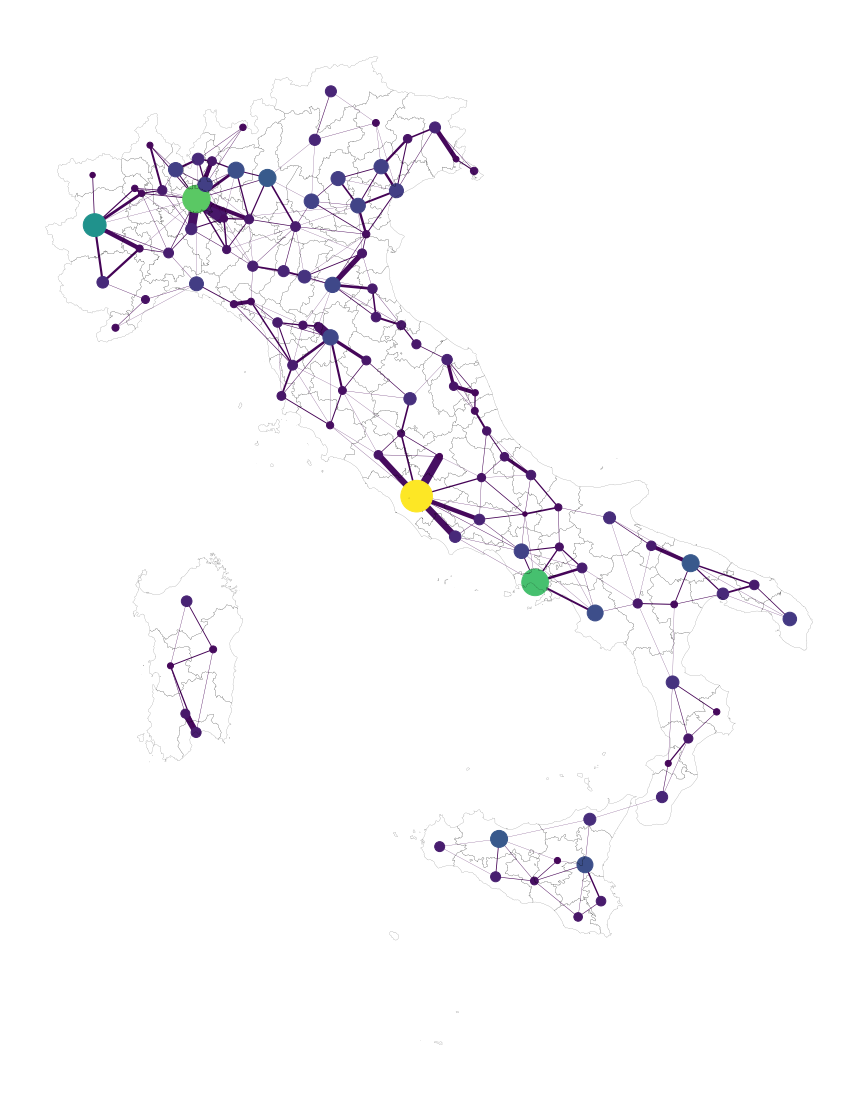

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))


networkx.draw(G, 
         G.position, 
         node_size=1000/max(s.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
           node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc'] for v in G],
          width = 200* np.array([max(a['weight'],0.001) for u,v,a in G.edges(data=True)]),
          edge_color=10* np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
#plt.xlim(min(s.pos_node[:,0]) - 100000, max(s.pos_node[:,0])+ 100000)
#plt.ylim(min(s.pos_node[:,1]) - 100000, max(s.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

s.shp.boundary.plot(ax = ax,  edgecolor="black", linewidth = .11)

plt.draw()

<AxesSubplot:>

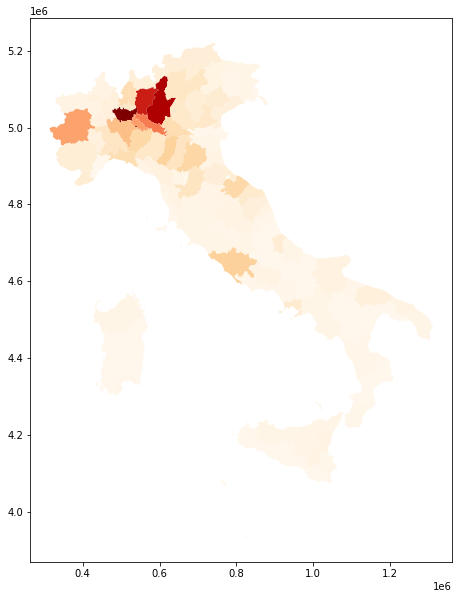

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
s.shp.plot(ax = ax, column='Rend', cmap='OrRd')#,  edgecolor="black") #facecolor="none",

(0.0, 0.0002)

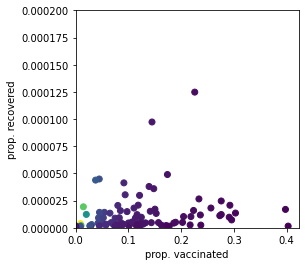

In [25]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(s.shp['vacc']/s.shp['population'], s.shp['Rend']/s.shp['population'], c= s.shp['population'])
ax.set_xlabel("prop. vaccinated")
ax.set_ylabel("prop. recovered");
ax.set_xlim(0)
ax.set_ylim(0, 0.0002)

In [26]:
G

/Users/chadi/.local/share/virtualenvs/COVID-19_Italy-vaccination-ocp-vr3EY8D_/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='vacc', ylabel='population'>

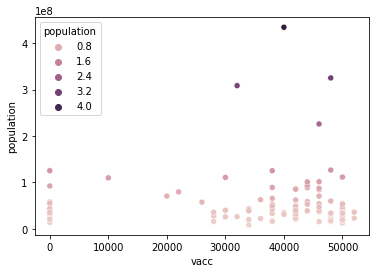

In [27]:
sns.scatterplot(s.shp['vacc'], s.shp['population']*100, hue= s.shp['population'])

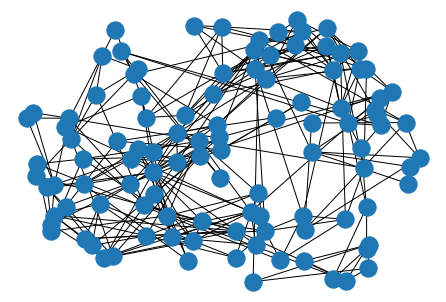

In [28]:
grph = networkx.from_numpy_matrix(mobility_history[0])
networkx.draw(grph)

In [29]:
# Find cutoff:
for u,v,a in G.edges('Sassari', data=True):
    print(a['weight']) 

0.9980178406001151
0.0043466788260032845
0.0014307002433242906


In [30]:
s.shp[85:]

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry,name,population,mobile_fraction,vacc,Rend
85,5,19,86,0,86,Enna,-,Enna,EN,Libero consorzio di comuni,351617.293464,2.573602e+09,"MULTIPOLYGON (((990240.628 4206801.292, 990204...",Enna,164790,0.40509,48000.000056,1.606908
86,5,19,87,287,287,-,Catania,Catania,CT,Citta metropolitana,517652.933581,3.575365e+09,"MULTIPOLYGON (((1023392.556 4214274.183, 10234...",Catania,1107700,0.42206,29999.996259,2.108588
87,5,19,88,0,88,Ragusa,-,Ragusa,RG,Libero consorzio di comuni,260829.399763,1.623292e+09,"MULTIPOLYGON (((1015701.907 4122875.255, 10157...",Ragusa,320890,0.45029,0.009485,0.288756
88,5,19,89,0,89,Siracusa,-,Siracusa,SR,Libero consorzio di comuni,377021.348497,2.122728e+09,"MULTIPOLYGON (((1025843.781 4156407.994, 10258...",Siracusa,399220,0.40586,29999.996341,0.721964
89,5,20,90,0,90,Sassari,-,Sassari,SS,Provincia,904619.966857,7.693553e+09,"MULTIPOLYGON (((518902.335 4567541.151, 518892...",Sassari,491570,0.44256,38000.001598,1.558751
90,5,20,91,0,91,Nuoro,-,Nuoro,NU,Provincia,555179.257146,5.639153e+09,"MULTIPOLYGON (((549256.099 4506292.616, 550959...",Nuoro,208550,0.41239,0.007821,0.158650
91,5,20,92,292,292,-,Cagliari,Cagliari,CA,Citta metropolitana,233440.679472,1.246640e+09,"MULTIPOLYGON (((531775.221 4363164.750, 531860...",Cagliari,431040,0.46179,33999.997170,0.948449
92,2,6,93,0,93,Pordenone,-,Pordenone,PN,Unità non amministrativa,277744.673487,2.275459e+09,"POLYGON ((770721.594 5143295.297, 770956.217 5...",Pordenone,312530,0.52511,39999.997920,1.053908
93,4,14,94,0,94,Isernia,-,Isernia,IS,Provincia,260963.457300,1.534487e+09,"POLYGON ((940185.641 4651530.883, 940230.891 4...",Isernia,84379,0.41454,34000.439941,0.131864
94,5,20,95,0,95,Oristano,-,Oristano,OR,Provincia,380638.799459,2.989282e+09,"MULTIPOLYGON (((457375.809 4475177.858, 457403...",Oristano,157710,0.40479,27999.991715,0.235089
